In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
import pandas as pd
import os
from PIL import Image
from sklearn.utils import class_weight
import numpy as np

# --- CONFIGURATION ---
DATA_DIR = '/Users/tejii.03/Documents/Projects/Skin Cancer Detection/Skin-Cancer-Detection/data'
IMAGE_FOLDER = os.path.join(DATA_DIR, 'images')
TRAIN_METADATA_PATH = os.path.join(DATA_DIR, 'train_metadata.csv')
VAL_METADATA_PATH = os.path.join(DATA_DIR, 'val_metadata.csv')

# --- NEW BINARY LABEL MAPPING ---
# 0: Benign (nv, bkl, vasc, df)
# 1: Malignant (mel, bcc, akiec)
BINARY_MAP = {
    'nv': 0, 'df': 0, 'vasc': 0, 'bkl': 0,
    'mel': 1, 'bcc': 1, 'akiec': 1
}
NEW_NUM_CLASSES = 2
BATCH_SIZE = 64
IMAGE_SIZE = 224
NUM_EPOCHS = 40 

# --- M4 GPU (MPS) Check ---
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Training device set to: {DEVICE}")

✅ Training device set to: mps


In [2]:
class BinaryHAM10000Dataset(torch.utils.data.Dataset):
    def __init__(self, metadata_path, image_folder, transform=None):
        self.data_frame = pd.read_csv(metadata_path)
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = {row['image_id']: os.path.join(image_folder, row['image_id'] + '.jpg')
                            for index, row in self.data_frame.iterrows()}
        # Use the new BINARY_MAP for labels
        self.data_frame['label'] = self.data_frame['dx'].map(BINARY_MAP)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        img_id = row['image_id']
        label = row['label']
        img_path = self.image_paths.get(img_id)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # Handle corrupt files by skipping to the next index
            return self.__getitem__((idx + 1) % self.__len__()) 

        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

In [3]:
# --- Data Transforms (Augmentation for Training, Minimal for Validation) ---
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Load DataLoaders ---
train_dataset = BinaryHAM10000Dataset(TRAIN_METADATA_PATH, IMAGE_FOLDER, train_transform)
val_dataset = BinaryHAM10000Dataset(VAL_METADATA_PATH, IMAGE_FOLDER, val_transform)

# num_workers=0 is best practice for Apple Silicon development
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Dataset Loaded. Training Binary Samples: {len(train_dataset)}")
print(f"Validation Binary Samples: {len(val_dataset)}")

Dataset Loaded. Training Binary Samples: 8012
Validation Binary Samples: 2003


In [4]:
def setup_model(num_classes, device):
    # Load ResNet50 with pre-trained ImageNet weights
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    
    # Freeze all parameters in the base model
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final classification layer for the new number of classes (2)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    # Move model to M4 GPU
    model = model.to(device)
    return model

model = setup_model(NEW_NUM_CLASSES, DEVICE)
print(f"Model loaded and adapted for {NEW_NUM_CLASSES} classes.")

Model loaded and adapted for 2 classes.


In [5]:
# --- LOSS FUNCTION (Recalculated Weights for Binary Imbalance) ---

# Get the new binary labels from the training set
train_labels = train_dataset.data_frame['label'].values

# Compute the new balanced weights (Inverse proportionality to class frequency)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert weights to a PyTorch tensor and move to GPU
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
print("Calculated Binary Class Weights (on GPU):", weights_tensor)

# Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# Only optimize the newly added classification layer (model.fc)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Calculated Binary Class Weights (on GPU): tensor([0.6212, 2.5630], device='mps:0')


In [6]:
def train_model(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct_predictions += torch.sum(preds == labels.data)

    scheduler.step()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    # M4 GPU Fix: Use .float()
    epoch_acc = correct_predictions.float() / len(train_loader.dataset)
    
    return epoch_loss, epoch_acc.item()

@torch.no_grad()
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        correct_predictions += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(val_loader.dataset)
    # M4 GPU Fix: Use .float()
    epoch_acc = correct_predictions.float() / len(val_loader.dataset)
    
    return epoch_loss, epoch_acc.item()

In [7]:
# --- MAIN TRAINING LOOP ---
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print(f"\nStarting Binary Classification Training for {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, scheduler, DEVICE)
    val_loss, val_acc = validate_model(model, val_loader, criterion, DEVICE)
    
    # Record history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Training Complete!")

# Save the final trained binary model to the root project directory
torch.save(model.state_dict(), 'skin_cancer_resnet50_binary.pth')
print("Binary Model saved.")


Starting Binary Classification Training for 40 epochs...
Epoch 1/40 - Train Loss: 0.5419, Train Acc: 0.7098 | Val Loss: 0.4717, Val Acc: 0.6995
Epoch 2/40 - Train Loss: 0.4746, Train Acc: 0.7545 | Val Loss: 0.5388, Val Acc: 0.6345
Epoch 3/40 - Train Loss: 0.4745, Train Acc: 0.7566 | Val Loss: 0.4389, Val Acc: 0.7454
Epoch 4/40 - Train Loss: 0.4599, Train Acc: 0.7695 | Val Loss: 0.4282, Val Acc: 0.7833
Epoch 5/40 - Train Loss: 0.4531, Train Acc: 0.7700 | Val Loss: 0.4295, Val Acc: 0.7688
Epoch 6/40 - Train Loss: 0.4325, Train Acc: 0.7780 | Val Loss: 0.4348, Val Acc: 0.8033
Epoch 7/40 - Train Loss: 0.4585, Train Acc: 0.7671 | Val Loss: 0.5130, Val Acc: 0.6590
Epoch 8/40 - Train Loss: 0.4296, Train Acc: 0.7740 | Val Loss: 0.4316, Val Acc: 0.7893
Epoch 9/40 - Train Loss: 0.4250, Train Acc: 0.7810 | Val Loss: 0.4290, Val Acc: 0.7753
Epoch 10/40 - Train Loss: 0.4181, Train Acc: 0.7917 | Val Loss: 0.4298, Val Acc: 0.7584
Epoch 11/40 - Train Loss: 0.4224, Train Acc: 0.7846 | Val Loss: 0.4314,

In [8]:
'''
Understanding the accuracy of the model with different metrics
'''

'\nUnderstanding the accuracy of the model with different metrics\n'

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Load the Best Model Weights ---
# NOTE: We load the weights from the file saved at the end of training.
model.load_state_dict(torch.load('skin_cancer_resnet50_binary.pth', map_location=DEVICE))
model.eval() # Set the model to evaluation mode
print("Model weights loaded successfully.")

# --- 2. Collect Predictions and True Labels ---
true_labels = []
all_probabilities = []
all_predictions = []

@torch.no_grad()
def collect_predictions(model, loader, device):
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        
        # Get probabilities (needed for ROC/AUC)
        probabilities = torch.softmax(outputs, dim=1)
        all_probabilities.extend(probabilities.cpu().numpy())
        
        # Get predicted classes
        _, preds = torch.max(outputs, 1)
        all_predictions.extend(preds.cpu().numpy())
        
        # Get true classes
        true_labels.extend(labels.cpu().numpy())

collect_predictions(model, val_loader, DEVICE)

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# Get probabilities for the Malignant class (index 1)
malignant_probabilities = all_probabilities[:, 1]

print(f"Collected {len(true_labels)} predictions from the validation set.")

Model weights loaded successfully.
Collected 2003 predictions from the validation set.


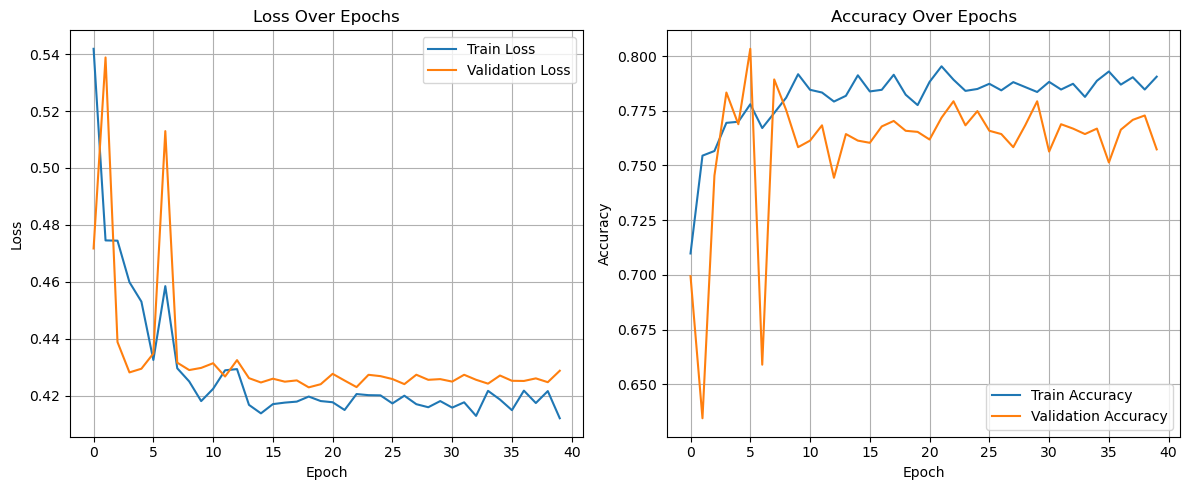

In [10]:
# Assuming the 'history' dictionary (from the last executed cell) holds the 40 epochs
plt.figure(figsize=(12, 5))

# Plot 1: Loss over Epochs
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('binary_loss_plot.png') # Save plot 1

# Plot 2: Accuracy over Epochs
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('binary_accuracy_plot.png') # Save plot 2
plt.show()

--- Classification Report (F1-Score, Precision, Recall) ---
               precision    recall  f1-score   support

   Benign (0)       0.95      0.73      0.83      1612
Malignant (1)       0.44      0.86      0.58       391

     accuracy                           0.76      2003
    macro avg       0.70      0.80      0.70      2003
 weighted avg       0.85      0.76      0.78      2003



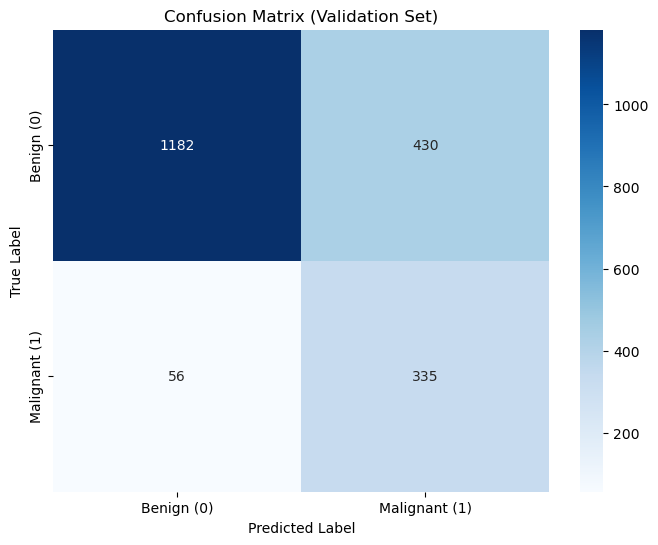

In [11]:
# Define target names based on the BINARY_MAP
target_names = ['Benign (0)', 'Malignant (1)']

# --- Classification Report (F1-Score, Precision, Recall) ---
print("--- Classification Report (F1-Score, Precision, Recall) ---")
print(classification_report(true_labels, all_predictions, target_names=target_names))

# --- Confusion Matrix ---
cm = confusion_matrix(true_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('binary_confusion_matrix.png') # Save plot 3
plt.show()

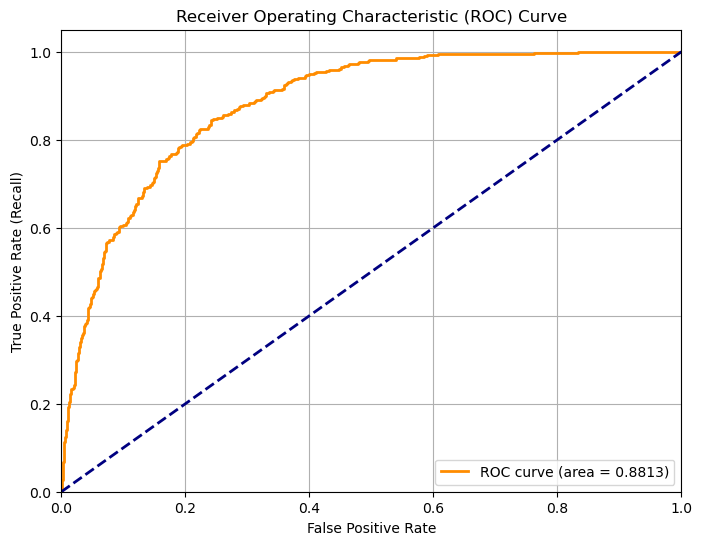

Final Area Under the Curve (AUC) for Malignant Class: 0.8813


In [12]:
# Calculate ROC curve and AUC for the Malignant class (index 1)
# Note: Since the problem is binary, we can treat class 1 (Malignant) as the positive class.
fpr, tpr, thresholds = roc_curve(true_labels, malignant_probabilities, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('binary_roc_auc_curve.png') # Save plot 4
plt.show()

print(f"Final Area Under the Curve (AUC) for Malignant Class: {roc_auc:.4f}")